In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.options.display.max_columns = 100
plt.style.use('ggplot')
import seaborn as sns
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder,MinMaxScaler
from sklearn.model_selection import KFold,RandomizedSearchCV,StratifiedKFold,train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
import xgboost as xgb

In [28]:
train = pd.read_csv("train.csv")
test  = pd.read_csv("test.csv")

In [29]:
train.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender,Interest_Rate
0,10000001,"7,000",< 1 year,Rent,68000.0,not verified,car,18.37,0,NaN,9,14,Female,1
1,10000002,"30,000",4 years,Mortgage,NaN,VERIFIED - income,debt_consolidation,14.93,0,17.0,12,24,Female,3
2,10000003,"24,725",7 years,Mortgage,75566.4,VERIFIED - income source,debt_consolidation,15.88,0,NaN,12,16,Male,3
3,10000004,"16,000",< 1 year,NaN,56160.0,VERIFIED - income source,debt_consolidation,14.34,3,NaN,16,22,Male,3
4,10000005,"17,000",8 years,Own,96000.0,VERIFIED - income source,debt_consolidation,22.17,1,NaN,19,30,Female,1


In [9]:
test.head()

,Loan_ID,Loan_Amount_Requested,Length_Employed,Home_Owner,Annual_Income,Income_Verified,Purpose_Of_Loan,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Gender
0,10164310,"27,500",10+ years,Mortgage,129000.0,VERIFIED - income,debt_consolidation,12.87,0,68.0,10,37,Male
1,10164311,"26,000",10+ years,NaN,110000.0,not verified,credit_card,11.37,0,NaN,6,23,Male
2,10164312,"6,075",< 1 year,Rent,75000.0,VERIFIED - income,debt_consolidation,6.83,2,NaN,5,20,Male
3,10164313,"12,000",10+ years,Mortgage,73000.0,VERIFIED - income source,debt_consolidation,7.76,0,NaN,6,8,Male
4,10164314,"35,000",< 1 year,Mortgage,156000.0,not verified,debt_consolidation,9.62,0,26.0,9,21,Male


In [3]:
train.shape, test.shape

((164309, 14), (109541, 13))

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 164309 entries, 0 to 164308
Data columns (total 14 columns):
Loan_ID                    164309 non-null int64
Loan_Amount_Requested      164309 non-null object
Length_Employed            156938 non-null object
Home_Owner                 138960 non-null object
Annual_Income              139207 non-null float64
Income_Verified            164309 non-null object
Purpose_Of_Loan            164309 non-null object
Debt_To_Income             164309 non-null float64
Inquiries_Last_6Mo         164309 non-null int64
Months_Since_Deliquency    75930 non-null float64
Number_Open_Accounts       164309 non-null int64
Total_Accounts             164309 non-null int64
Gender                     164309 non-null object
Interest_Rate              164309 non-null int64
dtypes: float64(3), int64(5), object(6)
memory usage: 17.6+ MB


In [5]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109541 entries, 0 to 109540
Data columns (total 13 columns):
Loan_ID                    109541 non-null int64
Loan_Amount_Requested      109541 non-null object
Length_Employed            104605 non-null object
Home_Owner                 92830 non-null object
Annual_Income              92643 non-null float64
Income_Verified            109541 non-null object
Purpose_Of_Loan            109541 non-null object
Debt_To_Income             109541 non-null float64
Inquiries_Last_6Mo         109541 non-null int64
Months_Since_Deliquency    50682 non-null float64
Number_Open_Accounts       109541 non-null int64
Total_Accounts             109541 non-null int64
Gender                     109541 non-null object
dtypes: float64(3), int64(4), object(6)
memory usage: 10.9+ MB


In [7]:
(train.isnull().sum()/train.shape[0])*100

Loan_ID                     0.000000
Loan_Amount_Requested       0.000000
Length_Employed             4.486060
Home_Owner                 15.427639
Annual_Income              15.277313
Income_Verified             0.000000
Purpose_Of_Loan             0.000000
Debt_To_Income              0.000000
Inquiries_Last_6Mo          0.000000
Months_Since_Deliquency    53.788289
Number_Open_Accounts        0.000000
Total_Accounts              0.000000
Gender                      0.000000
Interest_Rate               0.000000
dtype: float64

1. 6 Variables are of object data type.
2. 3 Variables are of float type and 4 are of int type.
3. 4 variables have missing values (Type_of_Cab,Customer_Since_Months,Life_Style_Index,Confidence_Life_Style_Index,Var1).
4. No Datetime Variable here.
5. Months_Since_Deliquency variable has more than 53% missing values, this can either be dropped from the dataset or values can be imputed accordingly.
6. Home_Owner and Annual_Income have same number of missing values which might indicate that for a particular record both Home_Owner and Annual_Income are missing. 

In [30]:
# Creating Submission dataframe with just Loan_ID column.
Submission=test[['Loan_ID']]
test.drop("Loan_ID",axis=1,inplace=True)

In [31]:
## For Annual_Income we can replace with median 

train["Annual_Income"].fillna(train["Annual_Income"].median(),inplace=True)

In [55]:
## For Annual_Income we can replace with median 

test["Annual_Income"].fillna(test["Annual_Income"].median(),inplace=True)

In [32]:
## Lets replace Length_Employed with most frequent or mode value as it is a categorical feature

train["Length_Employed"].fillna(train["Length_Employed"].value_counts().idxmax(),inplace=True)
## Lets replace Home_Owner with most frequent or mode value as it is a categorical feature

train["Home_Owner"].fillna(train["Home_Owner"].value_counts().idxmax(),inplace=True)

In [56]:
## Lets replace Length_Employed with most frequent or mode value as it is a categorical feature

test["Length_Employed"].fillna(test["Length_Employed"].value_counts().idxmax(),inplace=True)
## Lets replace Home_Owner with most frequent or mode value as it is a categorical feature

test["Home_Owner"].fillna(test["Home_Owner"].value_counts().idxmax(),inplace=True)

In [58]:
(train.isnull().sum()/train.shape[0])*100

Loan_ID                    0.0
Loan_Amount_Requested      0.0
Length_Employed            0.0
Home_Owner                 0.0
Annual_Income              0.0
Income_Verified            0.0
Purpose_Of_Loan            0.0
Debt_To_Income             0.0
Inquiries_Last_6Mo         0.0
Months_Since_Deliquency    0.0
Number_Open_Accounts       0.0
Total_Accounts             0.0
Gender                     0.0
Interest_Rate              0.0
dtype: float64

In [59]:
(test.isnull().sum()/test.shape[0])*100

Loan_Amount_Requested       0.000000
Length_Employed             0.000000
Home_Owner                  0.000000
Annual_Income               0.000000
Income_Verified             0.000000
Purpose_Of_Loan             0.000000
Debt_To_Income              0.000000
Inquiries_Last_6Mo          0.000000
Months_Since_Deliquency    53.732392
Number_Open_Accounts        0.000000
Total_Accounts              0.000000
Gender                      0.000000
dtype: float64

## EDA

### Dependent Variable

In [14]:
train['Interest_Rate'].value_counts(dropna=False)

2    70580
3    59923
1    33806
Name: Interest_Rate, dtype: int64

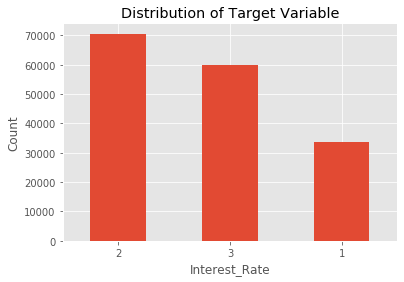

In [15]:
train['Interest_Rate'].value_counts(dropna=False).plot(kind='bar');
plt.xticks(rotation=360);
plt.xlabel("Interest_Rate");
plt.ylabel("Count");
plt.title("Distribution of Target Variable");

### Independent Variable

#### Loan_Amount_Requested

In [37]:
train.Loan_Amount_Requested=train.Loan_Amount_Requested.str.replace(',','')

In [38]:
train.Loan_Amount_Requested=train.Loan_Amount_Requested.astype(int)

In [10]:
train.Loan_Amount_Requested.describe()

count    164309.00000
mean      14349.33692
std        8281.86870
min         500.00000
25%        8000.00000
50%       12075.00000
75%       20000.00000
max       35000.00000
Name: Loan_Amount_Requested, dtype: float64

1. The Mean Loan_Amount_Requested is 44.2014349.33692 units.
2. Minimum seems to be 500.00000 units which is too less and can be an anomaly.
3. Maximum is 35000.00000 units. 
4. The median value is 12075 units.

In [52]:
test.Loan_Amount_Requested=test.Loan_Amount_Requested.str.replace(',','')

In [53]:
test.Loan_Amount_Requested=test.Loan_Amount_Requested.astype(int)

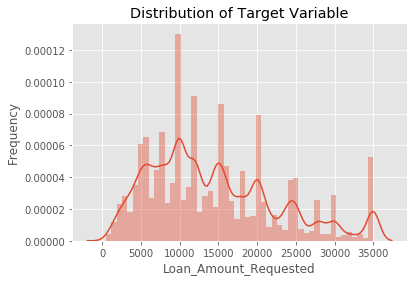

In [7]:
sns.distplot(train['Loan_Amount_Requested']);
plt.title("Distribution of Target Variable");
plt.ylabel("Frequency");
# Doesn't look like a normal distribution. 

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

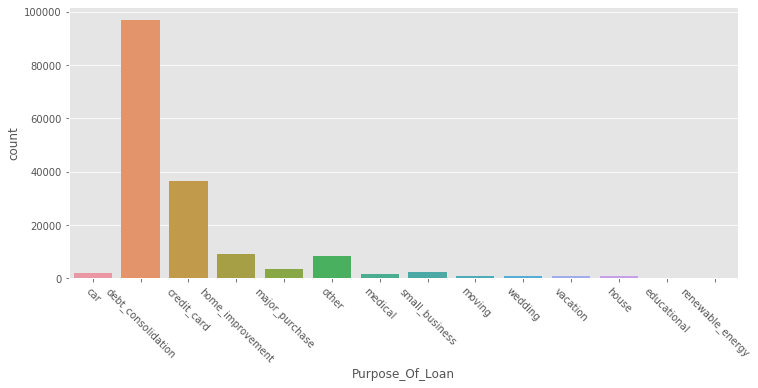

In [88]:
plt.figure(figsize=(12,5))
sns.countplot(train.Purpose_Of_Loan)
plt.xticks(rotation=-45)

Most of the borrowers are seeking a loan for debt consolidation following  credit card payment.

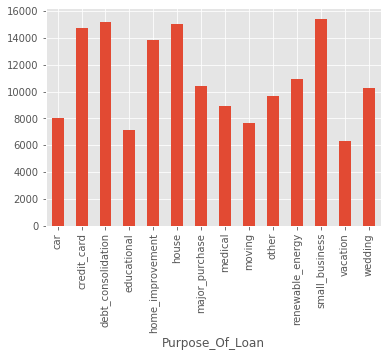

In [89]:
train.groupby('Purpose_Of_Loan')['Loan_Amount_Requested'].mean().plot(kind='bar')

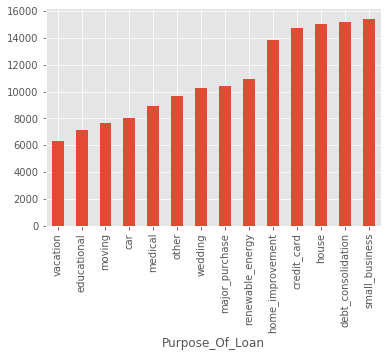

In [90]:
train.groupby('Purpose_Of_Loan')['Loan_Amount_Requested'].mean().sort_values().plot(kind='bar')

In [17]:
train.groupby('Purpose_Of_Loan')['Loan_Amount_Requested'].mean().sort_values()

Purpose_Of_Loan
vacation               6300.627240
educational            7110.123967
moving                 7668.814168
car                    8053.806366
medical                8913.854640
other                  9635.493051
wedding               10239.402174
major_purchase        10394.657933
renewable_energy      10958.130081
home_improvement      13867.466825
credit_card           14754.313870
house                 15042.205692
debt_consolidation    15148.553568
small_business        15427.456104
Name: Loan_Amount_Requested, dtype: float64

The average amount requested for loan is highest for Small business, followed by debt_consolidation and home.

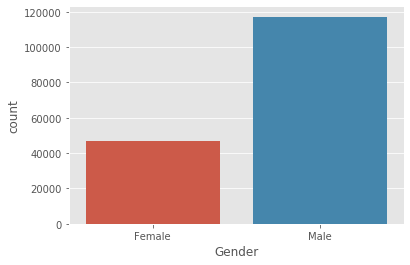

In [14]:
sns.countplot(train.Gender)

Most of the Male applicants have applied for a loan.

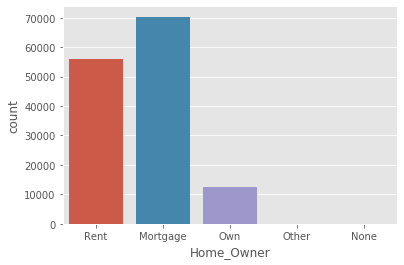

In [15]:
sns.countplot(train.Home_Owner)

Most of the applicants have either Mortgaged their house or are staying in a rented house.

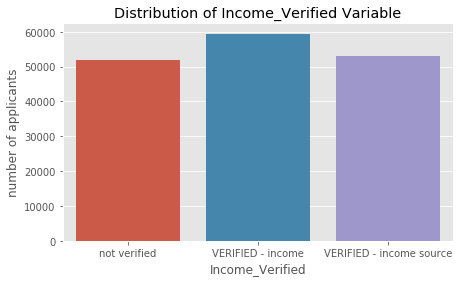

In [25]:
plt.figure(figsize=(7,4))
sns.countplot(train.Income_Verified)
plt.title("Distribution of Income_Verified Variable");
plt.ylabel("number of applicants");
# Doesn't look like a normal distribution. 

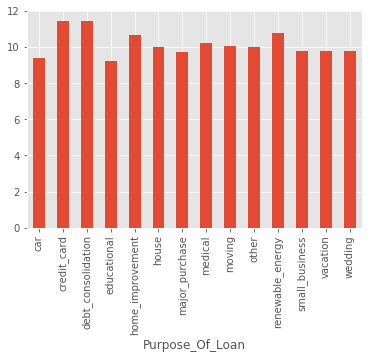

In [27]:
train.groupby('Purpose_Of_Loan')['Number_Open_Accounts'].mean().plot(kind='bar')

Applicants who have credit cards and debts, have the highest number of open accounts on an average.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13]),
 <a list of 14 Text xticklabel objects>)

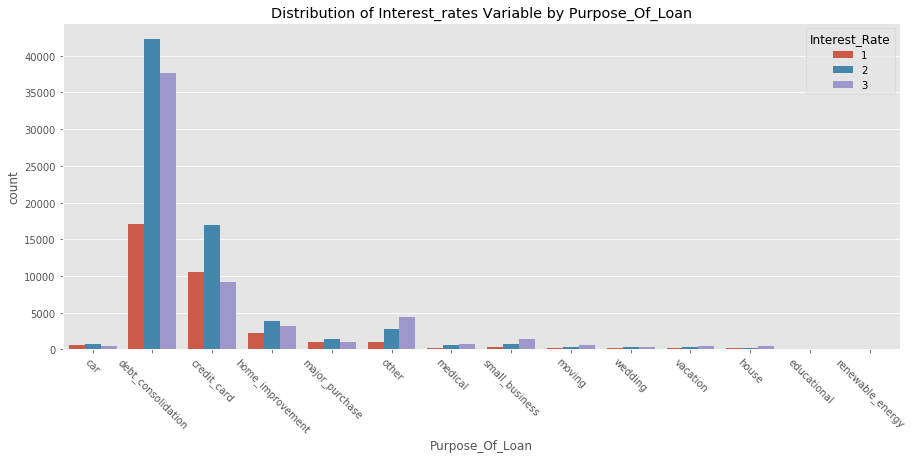

In [36]:
plt.figure(figsize=(15,6))
sns.countplot(x=train.Purpose_Of_Loan,hue=train.Interest_Rate)
plt.title("Distribution of Interest_rates Variable by Purpose_Of_Loan")
plt.xticks(rotation=-45)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

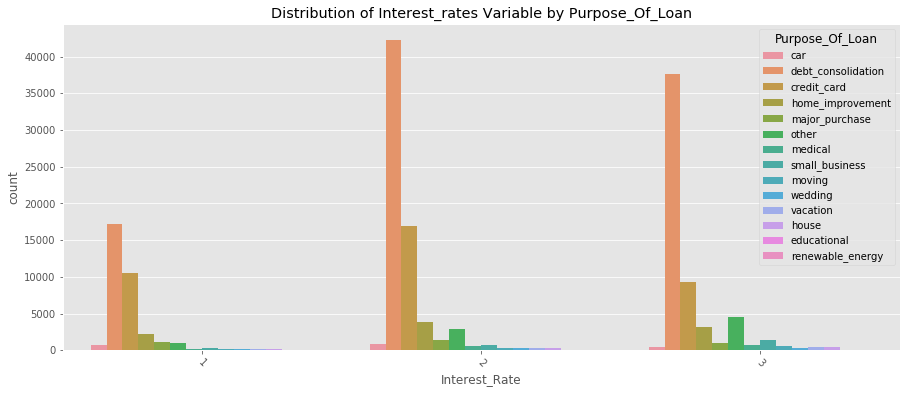

In [37]:
plt.figure(figsize=(15,6))
sns.countplot(x=train.Interest_Rate,hue=train.Purpose_Of_Loan)
plt.title("Distribution of Interest_rates Variable by Purpose_Of_Loan")
plt.xticks(rotation=-45)

All the Interest rates are higher for debt_consolidation and credit card.

(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

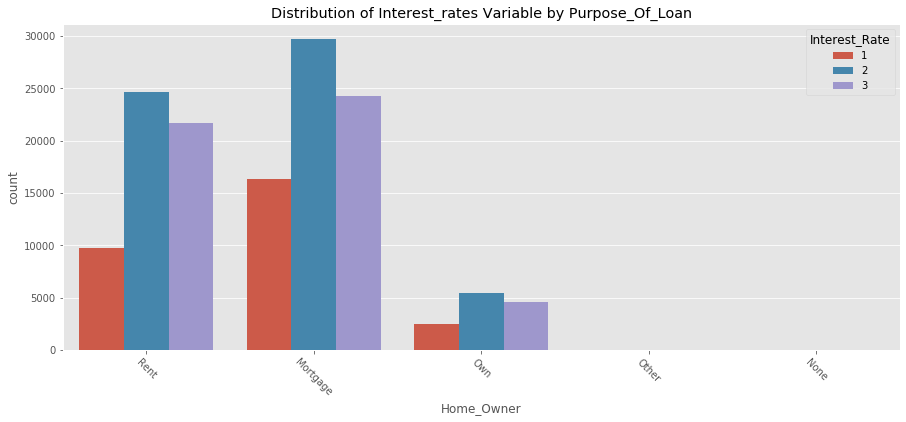

In [38]:
plt.figure(figsize=(15,6))
sns.countplot(x=train.Home_Owner,hue=train.Interest_Rate)
plt.title("Distribution of Interest_rates Variable by Purpose_Of_Loan")
plt.xticks(rotation=-45)

(array([0, 1, 2]), <a list of 3 Text xticklabel objects>)

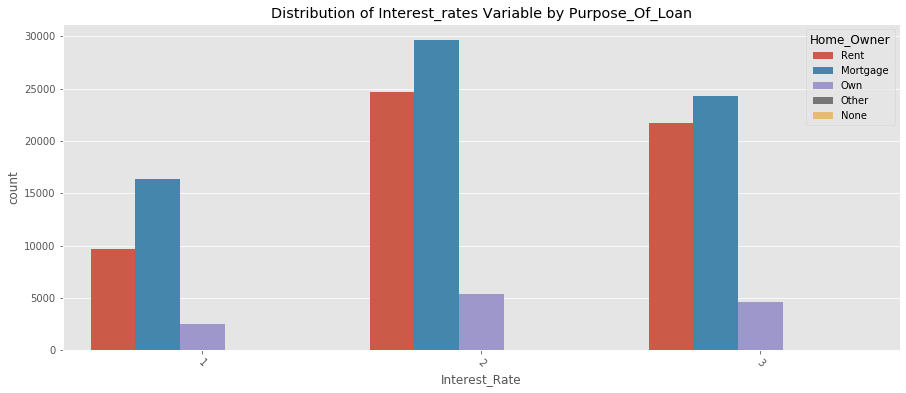

In [39]:
plt.figure(figsize=(15,6))
sns.countplot(x=train.Interest_Rate,hue=train.Home_Owner)
plt.title("Distribution of Interest_rates Variable by Purpose_Of_Loan")
plt.xticks(rotation=-45)

Interest rate 2 and 3 is highest for rent and Mortgage.

In [11]:
numerical_features=train.select_dtypes(include='number')
discrete_feature=[feature for feature in numerical_features if len(train[feature].unique())<25 
                  and feature not in ["Id"]]
continuous_feature=[feature for feature in numerical_features if feature not in discrete_feature+['Id']]
print("Continuous feature Count {}".format(len(continuous_feature)))
continuous_feature

Continuous feature Count 7


['Loan_ID',
 'Loan_Amount_Requested',
 'Annual_Income',
 'Debt_To_Income',
 'Months_Since_Deliquency',
 'Number_Open_Accounts',
 'Total_Accounts']

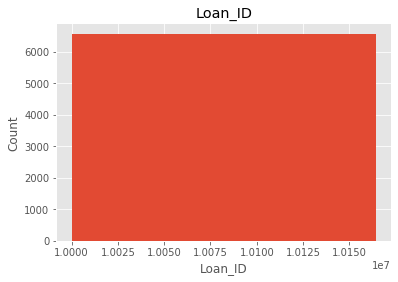

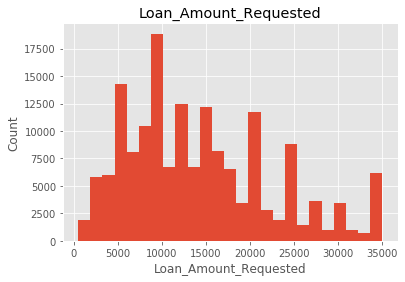

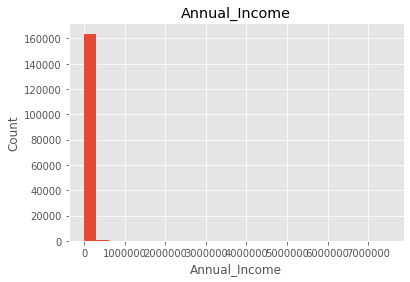

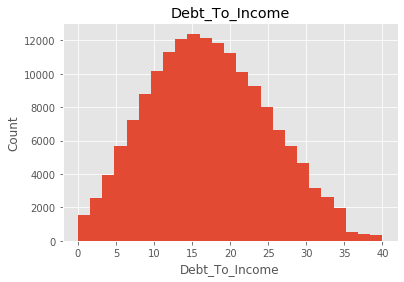

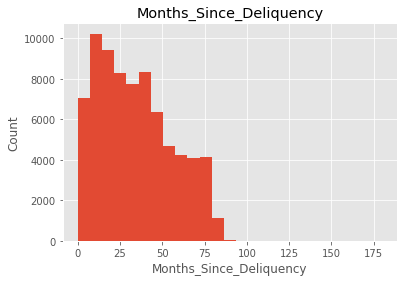

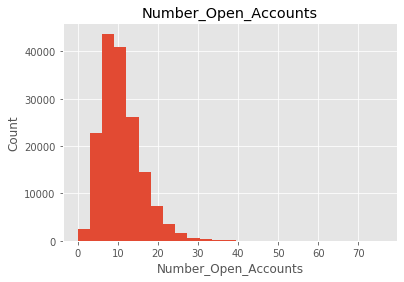

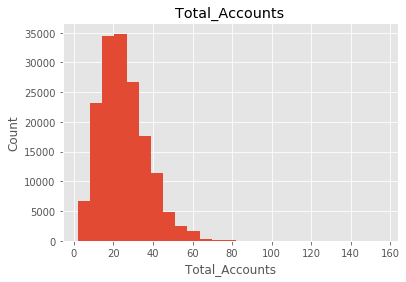

In [12]:
## Lets analyse the continuous values by creating histograms to understand the distribution

for feature in continuous_feature:
    data=train.copy()
    data[feature].hist(bins=25)
    plt.xlabel(feature)
    plt.ylabel("Count")
    plt.title(feature)
    plt.show()

In [81]:
train.Annual_Income.value_counts().head(20)

63000.0     25874
60000.0      5462
50000.0      4783
65000.0      4012
40000.0      3856
70000.0      3667
45000.0      3614
75000.0      3434
80000.0      3429
55000.0      3320
90000.0      2637
100000.0     2618
85000.0      2377
35000.0      2350
30000.0      2248
120000.0     1981
42000.0      1905
52000.0      1861
48000.0      1786
110000.0     1581
Name: Annual_Income, dtype: int64

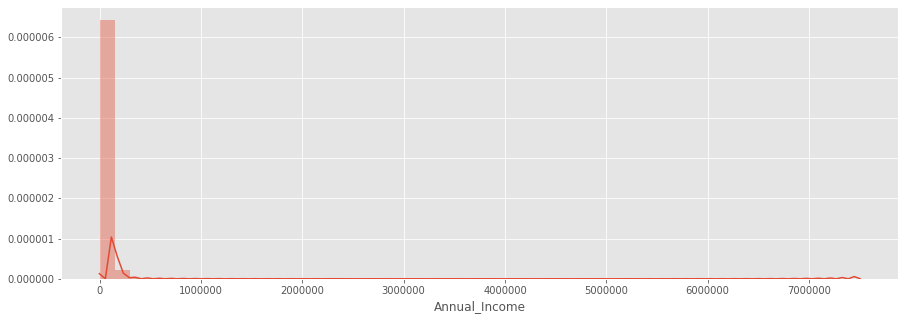

In [79]:
plt.figure(figsize=(15,5))
sns.distplot(train.Annual_Income)

Most of the applicants have annual income less than 100000.

#### Treating missing value Months_Since_Deliquency

In [34]:
### We can replace the NAN values in Months_Since_Deliquency with respect to Home_Owner

def impute_Months_Since_Deliquency(cols):
    Months_Since_Deliquency=cols[0]
    Home_Owner=cols[1]
    if pd.isnull(Months_Since_Deliquency):
        if Home_Owner=="Rent":
            return 35
        elif Home_Owner=="Mortgage":
            return 30
        elif Home_Owner=="Own":
            return 35
        elif Home_Owner=="Other":
            return 45
        else:
            return 20
    else:
        return Months_Since_Deliquency

In [35]:
# Now applying the function in data

train["Months_Since_Deliquency"]=train[["Months_Since_Deliquency","Home_Owner"]].apply(impute_Months_Since_Deliquency,axis=1)

In [60]:
# Now applying the function in data

test["Months_Since_Deliquency"]=test[["Months_Since_Deliquency","Home_Owner"]].apply(impute_Months_Since_Deliquency,axis=1)

In [39]:
(train.isnull().sum()/train.shape[0])*100

Loan_ID                    0.0
Loan_Amount_Requested      0.0
Length_Employed            0.0
Home_Owner                 0.0
Annual_Income              0.0
Income_Verified            0.0
Purpose_Of_Loan            0.0
Debt_To_Income             0.0
Inquiries_Last_6Mo         0.0
Months_Since_Deliquency    0.0
Number_Open_Accounts       0.0
Total_Accounts             0.0
Gender                     0.0
Interest_Rate              0.0
dtype: float64

In [61]:
(test.isnull().sum()/test.shape[0])*100

Loan_Amount_Requested      0.0
Length_Employed            0.0
Home_Owner                 0.0
Annual_Income              0.0
Income_Verified            0.0
Purpose_Of_Loan            0.0
Debt_To_Income             0.0
Inquiries_Last_6Mo         0.0
Months_Since_Deliquency    0.0
Number_Open_Accounts       0.0
Total_Accounts             0.0
Gender                     0.0
dtype: float64

No missing values.

## Treating outliers

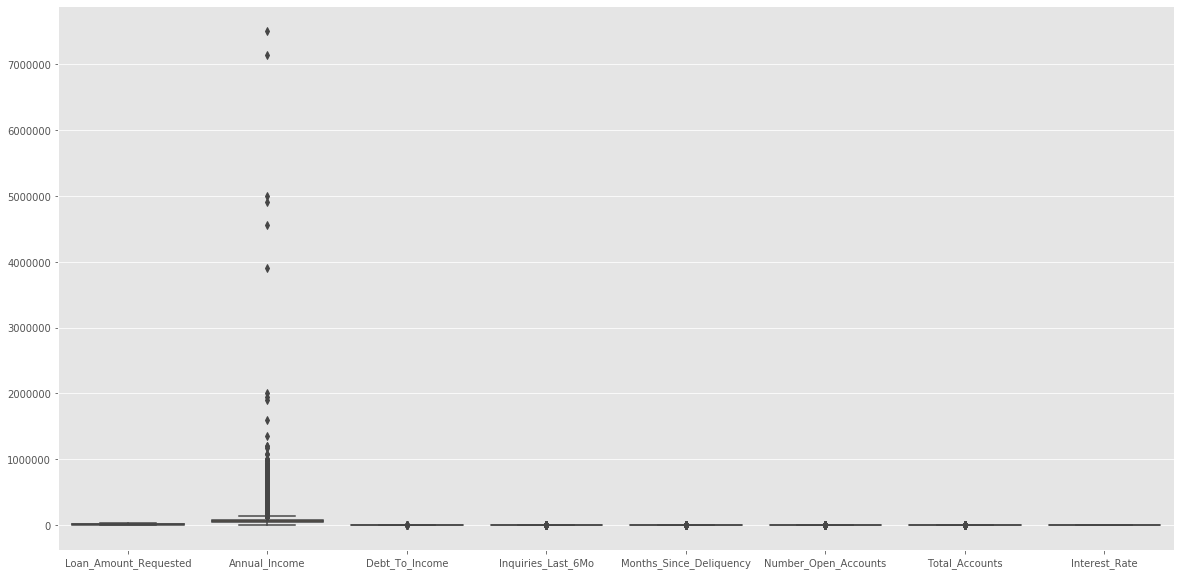

In [16]:
plt.figure(figsize=(20,10))
sns.boxplot(data=train.drop('Loan_ID',axis=1))

In [17]:
x=train.describe()
x

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate
count,1.643090e+05,164309.00000,1.643090e+05,164309.000000,164309.000000,164309.000000,164309.000000,164309.000000,164309.000000
mean,1.008216e+07,14349.33692,7.175284e+04,17.207189,0.781698,33.137564,11.193818,25.067665,2.158951
std,4.743207e+04,8281.86870,5.569855e+04,7.845083,1.034747,14.939882,4.991813,11.583067,0.738364
min,1.000000e+07,500.00000,4.000000e+03,0.000000,0.000000,0.000000,0.000000,2.000000,1.000000
25%,1.004108e+07,8000.00000,4.860000e+04,11.370000,0.000000,30.000000,8.000000,17.000000,2.000000
50%,1.008216e+07,12075.00000,6.300000e+04,16.840000,0.000000,30.000000,10.000000,23.000000,2.000000
75%,1.012323e+07,20000.00000,8.200000e+04,22.780000,1.000000,35.000000,14.000000,32.000000,3.000000
max,1.016431e+07,35000.00000,7.500000e+06,39.990000,8.000000,180.000000,76.000000,156.000000,3.000000


In [40]:
for i in numerical_features:
    q1=x.loc['25%',i]
    q3=x.loc['75%',i]
    iqr=q3-q1
    uppl=q3+(1.5*iqr)
    lowl=q1-(1.5*iqr)
    train[i]=train[i].apply(lambda x:uppl if x>uppl else x )
    train[i]=train[i].apply(lambda x: lowl if x<lowl else x)

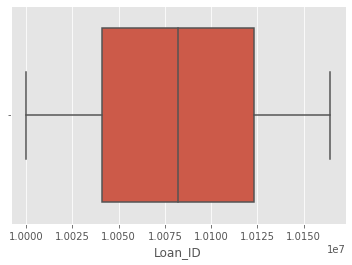

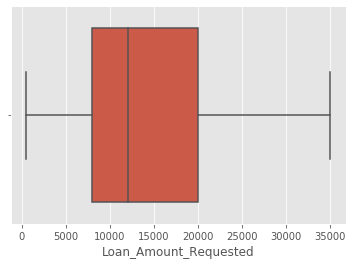

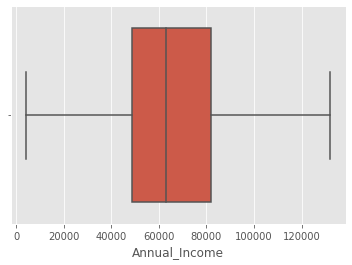

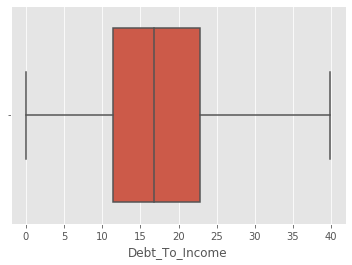

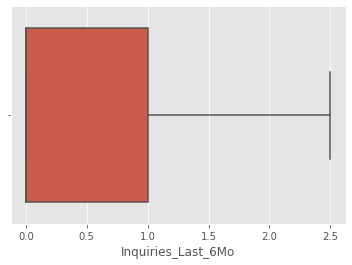

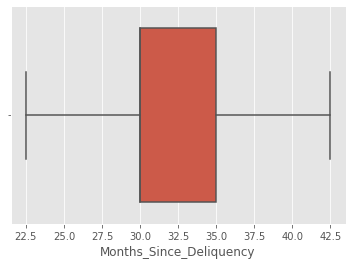

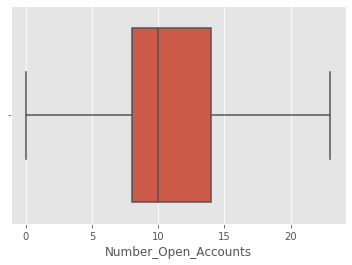

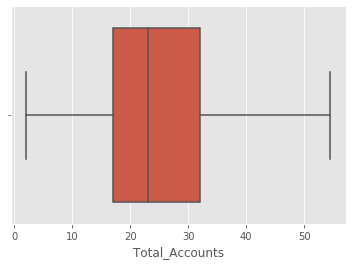

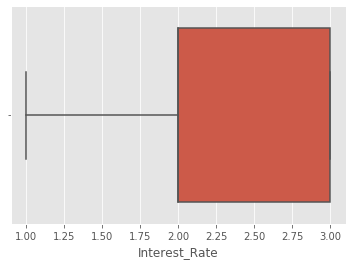

In [41]:
for i in numerical_features:
    sns.boxplot(train[i])
    plt.show()

In [25]:
train.select_dtypes(include='object').columns

Index(['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan',
       'Gender'],
      dtype='object')

In [42]:
data_dummy=pd.get_dummies(train,columns=['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan',
       'Gender'], drop_first=True)
data_dummy

,Loan_ID,Loan_Amount_Requested,Annual_Income,Debt_To_Income,Inquiries_Last_6Mo,Months_Since_Deliquency,Number_Open_Accounts,Total_Accounts,Interest_Rate,Length_Employed_10+ years,Length_Employed_2 years,Length_Employed_3 years,Length_Employed_4 years,Length_Employed_5 years,Length_Employed_6 years,Length_Employed_7 years,Length_Employed_8 years,Length_Employed_9 years,Length_Employed_< 1 year,Home_Owner_None,Home_Owner_Other,Home_Owner_Own,Home_Owner_Rent,Income_Verified_VERIFIED - income source,Income_Verified_not verified,Purpose_Of_Loan_credit_card,Purpose_Of_Loan_debt_consolidation,Purpose_Of_Loan_educational,Purpose_Of_Loan_home_improvement,Purpose_Of_Loan_house,Purpose_Of_Loan_major_purchase,Purpose_Of_Loan_medical,Purpose_Of_Loan_moving,Purpose_Of_Loan_other,Purpose_Of_Loan_renewable_energy,Purpose_Of_Loan_small_business,Purpose_Of_Loan_vacation,Purpose_Of_Loan_wedding,Gender_Male
0,10000001,7000,68000.0,18.37,0.0,35.0,9.0,14.0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,10000002,30000,63000.0,14.93,0.0,22.5,12.0,24.0,3,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,10000003,24725,75566.4,15.88,0.0,30.0,12.0,16.0,3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
3,10000004,16000,56160.0,14.34,2.5,30.0,16.0,22.0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1
4,10000005,17000,96000.0,22.17,1.0,35.0,19.0,30.0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
164304,10164305,20725,63000.0,13.56,0.0,35.0,13.0,16.0,2,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
164305,10164306,6000,63000.0,9.12,0.0,36.0,13.0,30.0,2,0,0,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1
164306,10164307,20250,63000.0,18.17,1.0,30.0,17.0,30.0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
164307,10164308,10000,63000.0,18.75,1.0,42.5,16.0,54.5,3,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [80]:
data_test_dummy=pd.get_dummies(test,columns=['Length_Employed', 'Home_Owner', 'Income_Verified', 'Purpose_Of_Loan',
       'Gender'], drop_first=True)

37

In [44]:
X=data_dummy.drop(['Interest_Rate','Loan_ID'],axis=1)
y=data_dummy.Interest_Rate

In [45]:
kf = StratifiedKFold(n_splits=5,shuffle=False,random_state=42)

In [46]:
clf = lgb.LGBMClassifier(boosting_type='gbdt',objective='multiclass',num_class=3,random_state=42,n_jobs=-1,verbose=1,)
params = {"max_depth":[4,6,8,10,-1],
          "learning_rate":[0.001,0.005,0.01,0.05,0.1,0.3],
          "subsample":[0.5,0.6,0.7,0.8,0.9],
          "colsample_bytree":[0.5,0.6,0.7,0.8,0.9],
          "reg_alpha":[0,0.25,0.5,1,2],
          "reg_lambda":[0,0.25,0.5,1,2],
          "num_leaves":[7,15,31,63,127],
          "min_data_in_leaf":[1,3,5,7,10,25],
          "n_estimators":list(range(50,1001,50))}
random_search = RandomizedSearchCV(estimator=clf,param_distributions=params,cv=kf.split(X,y),scoring='accuracy')
random_search.fit(X,y)

RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x00000027BDB41E48>,
                   error_score='raise-deprecating',
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_class=3,...
                                        'min_data_in_leaf': [1, 3, 5, 7, 10,
                                                             25],
                                        'n_estimator

In [47]:
random_search.best_estimator_,random_search.best_params_,random_search.best_score_

(LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
                importance_type='split', learning_rate=0.05, max_depth=6,
                min_child_samples=20, min_child_weight=0.001,
                min_data_in_leaf=10, min_split_gain=0.0, n_estimators=300,
                n_jobs=-1, num_class=3, num_leaves=127, objective='multiclass',
                random_state=42, reg_alpha=2, reg_lambda=0.25, silent=True,
                subsample=0.7, subsample_for_bin=200000, subsample_freq=0,
                verbose=1),
 {'subsample': 0.7,
  'reg_lambda': 0.25,
  'reg_alpha': 2,
  'num_leaves': 127,
  'n_estimators': 300,
  'min_data_in_leaf': 10,
  'max_depth': 6,
  'learning_rate': 0.05,
  'colsample_bytree': 0.5},
 0.5412058986421925)

In [48]:
pd.DataFrame(random_search.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_subsample,param_reg_lambda,param_reg_alpha,param_num_leaves,param_n_estimators,param_min_data_in_leaf,param_max_depth,param_learning_rate,param_colsample_bytree,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,18.672942,0.613166,2.775775,0.066745,0.7,0.25,2,127,300,10,6,0.05,0.5,"{'subsample': 0.7, 'reg_lambda': 0.25, 'reg_al...",0.539391,0.541050,0.542329,0.542436,0.540823,0.541206,0.001117,1
1,88.627132,6.314755,17.808815,2.175839,0.7,0.25,2,127,800,5,10,0.005,0.7,"{'subsample': 0.7, 'reg_lambda': 0.25, 'reg_al...",0.536165,0.535756,0.537886,0.537354,0.536076,0.536647,0.000823,3
2,38.741417,4.883086,3.859546,0.457140,0.5,0.25,0.5,31,600,5,4,0.001,0.8,"{'subsample': 0.5, 'reg_lambda': 0.25, 'reg_al...",0.486231,0.484207,0.489441,0.487843,0.488543,0.487253,0.001851,10
3,33.823527,2.620593,3.086196,0.256127,0.7,1,0.5,15,450,25,6,0.005,0.9,"{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha...",0.513465,0.514059,0.516098,0.516326,0.516387,0.515267,0.001247,7
4,26.173805,3.344320,4.411712,0.325128,0.9,0.5,0,31,550,25,6,0.3,0.6,"{'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alp...",0.531510,0.531739,0.535725,0.536076,0.535315,0.534073,0.002015,4
5,60.780847,5.480672,6.756745,0.779376,0.7,1,0,7,1000,7,6,0.001,0.6,"{'subsample': 0.7, 'reg_lambda': 1, 'reg_alpha...",0.493564,0.490932,0.494949,0.496090,0.499467,0.495000,0.002820,9
6,11.156711,0.650049,1.097153,0.124385,0.8,0.25,0.5,63,150,7,-1,0.3,0.9,"{'subsample': 0.8, 'reg_lambda': 0.25, 'reg_al...",0.537474,0.535695,0.536242,0.537841,0.537415,0.536933,0.000820,2
7,25.877131,0.123108,3.414229,0.043132,0.6,0,0.5,31,400,25,-1,0.005,0.5,"{'subsample': 0.6, 'reg_lambda': 0, 'reg_alpha...",0.518608,0.517558,0.521666,0.519491,0.519613,0.519387,0.001357,6
8,47.936085,0.138324,8.073743,0.427189,0.9,0.25,0,63,950,10,4,0.01,0.8,"{'subsample': 0.9, 'reg_lambda': 0.25, 'reg_al...",0.532149,0.529670,0.534538,0.534798,0.530416,0.532314,0.002085,5
9,57.212484,0.264971,8.894712,0.556392,0.6,0.5,2,127,850,5,-1,0.3,0.8,"{'subsample': 0.6, 'reg_lambda': 0.5, 'reg_alp...",0.510392,0.511716,0.508977,0.514379,0.512888,0.511670,0.001882,8


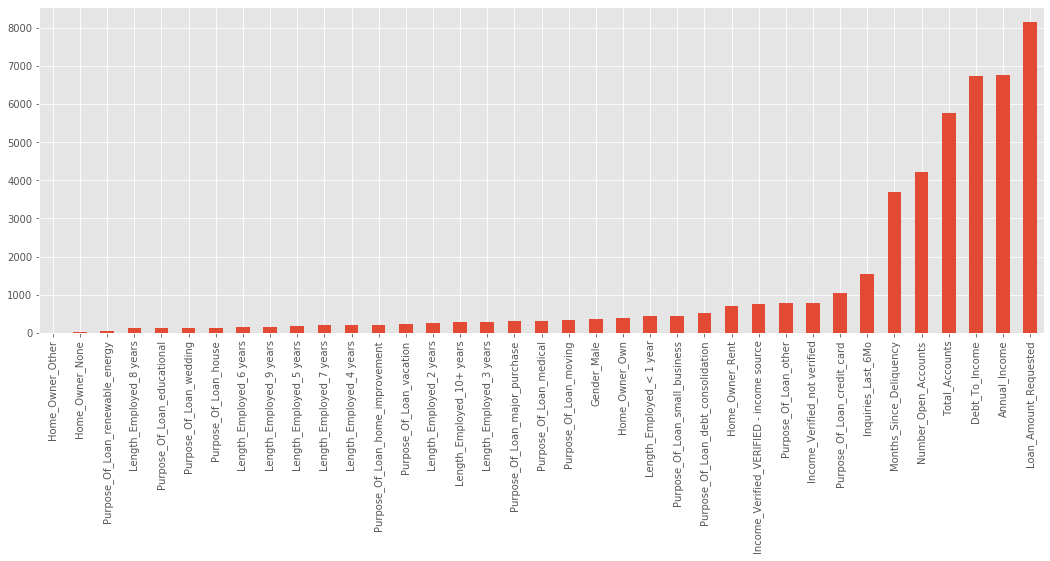

In [49]:
plt.figure(figsize=(18,6))
ser = pd.Series(random_search.best_estimator_.feature_importances_,X.columns).sort_values()
ser.plot(kind='bar')

In [81]:
Submission['Interest_Rate'] = random_search.best_estimator_.predict(data_test_dummy)
Submission.to_csv("Sub_13.csv",index=None)

C:\Users\Dell\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [83]:
pd.read_csv('Sub_13.csv')

,Loan_ID,Interest_Rate
0,10164310,2
1,10164311,2
2,10164312,3
3,10164313,2
4,10164314,2
...,...,...
109536,10273846,3
109537,10273847,2
109538,10273848,2
109539,10273849,3
